In [0]:
# Core PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, sum, avg, count, udf, split, floor
from pyspark.sql.types import StringType

# MLlib
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Handling
import pandas as pd
import numpy as np

# Start Spark session
spark = SparkSession.builder.appName("IPL_Project_Restart").getOrCreate()


In [0]:
deliveries_df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/nlsn@gmu.edu/deliveries-3.csv")
ball_by_ball_df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/nlsn@gmu.edu/IPL_BallByBall2008_2024_Updated_-3.csv")
team_info_df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/nlsn@gmu.edu/ipl_teams_2024_info-3.csv")
matches_df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/nlsn@gmu.edu/matches-3.csv")
players_info_df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/nlsn@gmu.edu/Players_Info_2024-3.csv")
team_perf_df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/nlsn@gmu.edu/team_performance_dataset_2008to2024-3.csv")

In [0]:
# Team name mapping for consistency across seasons
team_name_map = {
    "Delhi Daredevils": "Delhi Capitals",
    "Deccan Chargers": "Sunrisers Hyderabad",
    "Kings XI Punjab": "Punjab Kings",
    "Rising Pune Supergiant": "Rising Pune Supergiants",
    "Pune Warriors": "Rising Pune Supergiants",
    "Gujarat Lions": "Gujarat Titans"
}

# UDF to apply mapping
def normalize_team_name(name):
    return team_name_map.get(name, name)

normalize_team_udf = udf(normalize_team_name, StringType())

# Apply normalization to matches_df
for col_name in ["team1", "team2", "toss_winner", "winner"]:
    matches_df = matches_df.withColumn(col_name, normalize_team_udf(col(col_name)))

# Apply normalization to deliveries_df
for col_name in ["batting_team", "bowling_team"]:
    deliveries_df = deliveries_df.withColumn(col_name, normalize_team_udf(col(col_name)))

# Clean column names in ball_by_ball_df
ball_by_ball_df = ball_by_ball_df.toDF(*[c.strip().lower().replace(" ", "_") for c in ball_by_ball_df.columns])

# Normalize team names in ball_by_ball_df
for col_name in ["batting_team", "bowling_team"]:
    ball_by_ball_df = ball_by_ball_df.withColumn(col_name, normalize_team_udf(col(col_name)))

# Normalize and rename column in team_perf_df if needed
if "Teams" in team_perf_df.columns:
    team_perf_df = team_perf_df.withColumn("Teams", normalize_team_udf(col("Teams")))
    team_perf_df = team_perf_df.withColumnRenamed("Teams", "Team")



#EDA

## Toss Winner vs Match Winner

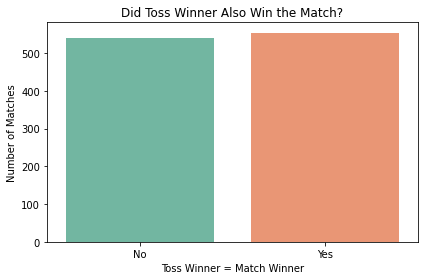

In [0]:
# Add a flag column indicating if toss winner also won the match
matches_df = matches_df.withColumn("toss_match_win", (col("toss_winner") == col("winner")))

# Group by this new flag
toss_win_stats = matches_df.groupBy("toss_match_win").count().toPandas()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=toss_win_stats, x="toss_match_win", y="count", palette="Set2")
plt.title("Did Toss Winner Also Win the Match?")
plt.xticks([0, 1], ["No", "Yes"])
plt.xlabel("Toss Winner = Match Winner")
plt.ylabel("Number of Matches")
plt.tight_layout()
plt.show()


## Toss Decision vs Match Outcome

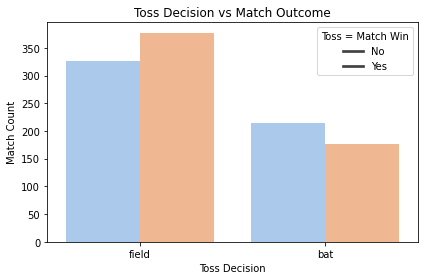

In [0]:
toss_outcome_df = matches_df.groupBy("toss_decision", "toss_match_win").count().toPandas()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(data=toss_outcome_df, x="toss_decision", y="count", hue="toss_match_win", palette="pastel")
plt.title("Toss Decision vs Match Outcome")
plt.xlabel("Toss Decision")
plt.ylabel("Match Count")
plt.legend(title="Toss = Match Win", labels=["No", "Yes"])
plt.tight_layout()
plt.show()


## Total Wins by Team

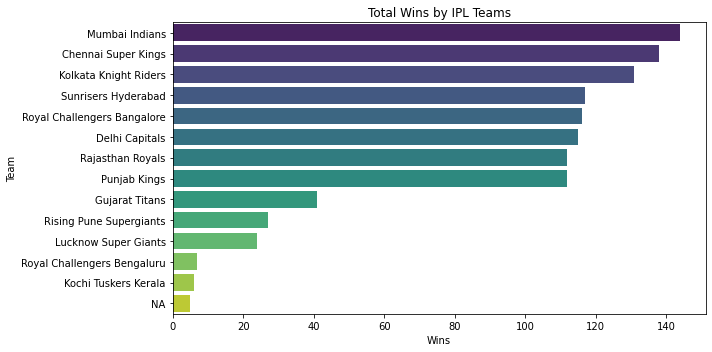

In [0]:
team_wins = matches_df.groupBy("winner").count().orderBy("count", ascending=False).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=team_wins, x="count", y="winner", palette="viridis")
plt.title("Total Wins by IPL Teams")
plt.xlabel("Wins")
plt.ylabel("Team")
plt.tight_layout()
plt.show()


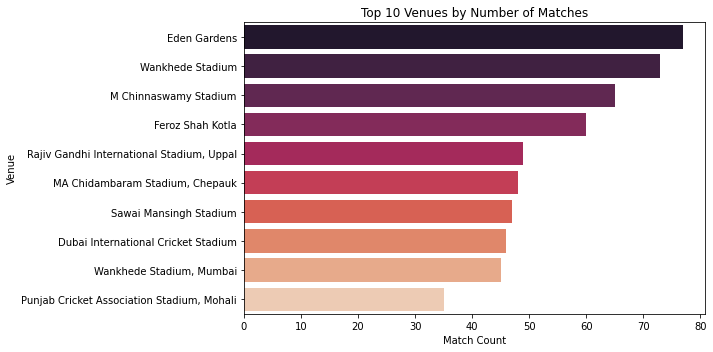

In [0]:
venue_counts = matches_df.groupBy("venue").count().orderBy("count", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=venue_counts, y="venue", x="count", palette="rocket")
plt.title("Top 10 Venues by Number of Matches")
plt.xlabel("Match Count")
plt.ylabel("Venue")
plt.tight_layout()
plt.show()


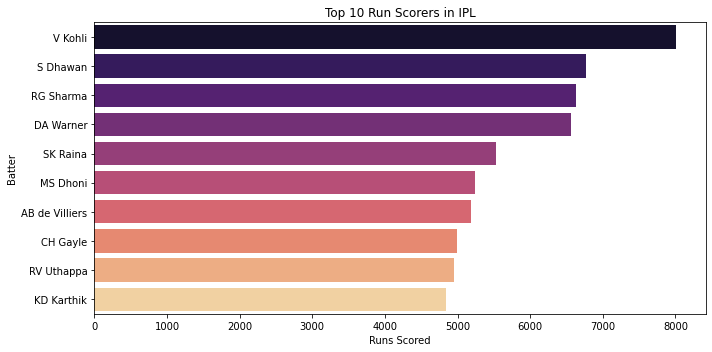

In [0]:
top_batters = deliveries_df.groupBy("batter").agg(sum("batsman_runs").alias("total_runs")) \
    .orderBy("total_runs", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=top_batters, x="total_runs", y="batter", palette="magma")
plt.title("Top 10 Run Scorers in IPL")
plt.xlabel("Runs Scored")
plt.ylabel("Batter")
plt.tight_layout()
plt.show()


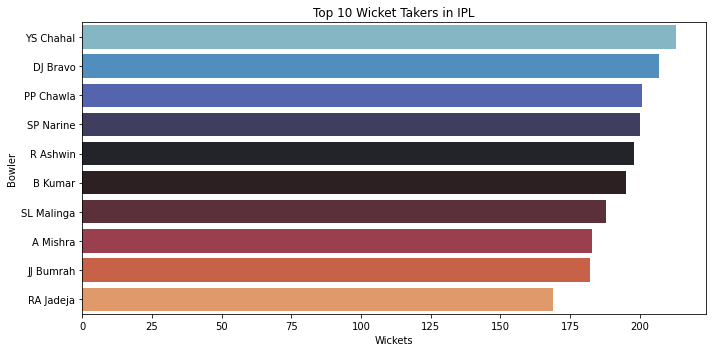

In [0]:
wickets_df = deliveries_df.filter((col("is_wicket") == 1) & col("dismissal_kind").isNotNull())

top_bowlers = wickets_df.groupBy("bowler").count().orderBy("count", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=top_bowlers, x="count", y="bowler", palette="icefire")
plt.title("Top 10 Wicket Takers in IPL")
plt.xlabel("Wickets")
plt.ylabel("Bowler")
plt.tight_layout()
plt.show()


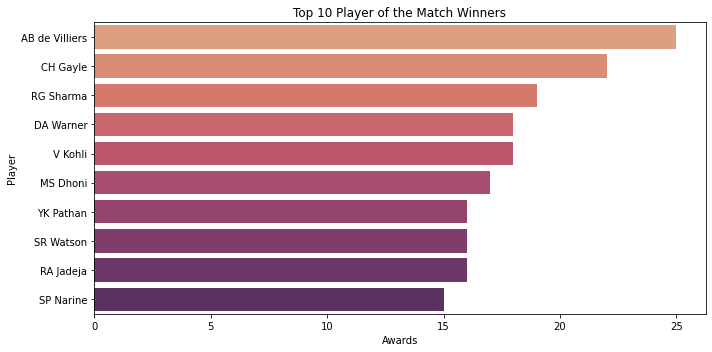

In [0]:
top_mvps = matches_df.groupBy("player_of_match").count().orderBy("count", ascending=False).limit(10).toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=top_mvps, x="count", y="player_of_match", palette="flare")
plt.title("Top 10 Player of the Match Winners")
plt.xlabel("Awards")
plt.ylabel("Player")
plt.tight_layout()
plt.show()


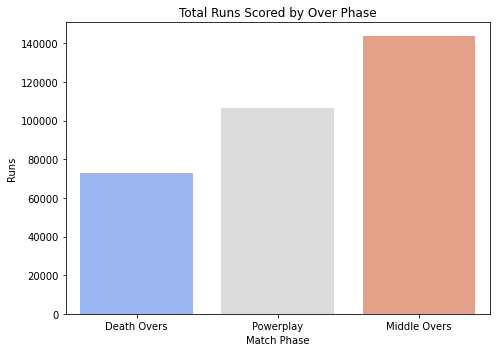

In [0]:
# Convert ball_no to over
ball_by_ball_df = ball_by_ball_df.withColumn("over", floor(col("ball_no")))

# Define over phases
ball_by_ball_df = ball_by_ball_df.withColumn("phase",
    when(col("over") <= 6, "Powerplay")
    .when((col("over") > 6) & (col("over") <= 15), "Middle Overs")
    .otherwise("Death Overs")
)

# Aggregate runs by phase
phase_runs = ball_by_ball_df.groupBy("phase").agg(sum("runs_scored").alias("total_runs")).toPandas()

# Plot
plt.figure(figsize=(7, 5))
sns.barplot(data=phase_runs, x="phase", y="total_runs", palette="coolwarm")
plt.title("Total Runs Scored by Over Phase")
plt.xlabel("Match Phase")
plt.ylabel("Runs")
plt.tight_layout()
plt.show()


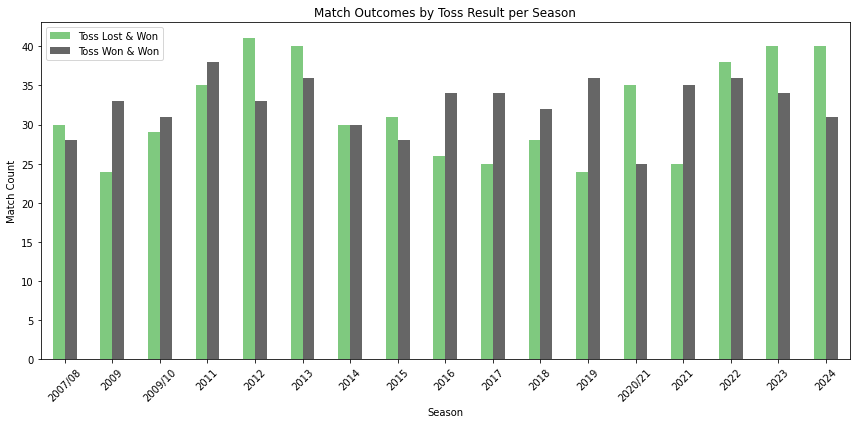

In [0]:
# Ensure column is present
matches_df = matches_df.withColumn("toss_match_win", matches_df["toss_winner"] == matches_df["winner"])

season_impact = matches_df.groupBy("season", "toss_match_win").count().toPandas()
pivot_season = season_impact.pivot(index="season", columns="toss_match_win", values="count").fillna(0)
pivot_season.columns = ["Toss Lost & Won", "Toss Won & Won"]

# Plot
pivot_season.plot(kind="bar", figsize=(12, 6), stacked=False, colormap="Accent")
plt.title("Match Outcomes by Toss Result per Season")
plt.ylabel("Match Count")
plt.xlabel("Season")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Feature Engineering

## Create Label and Bat First Team

In [0]:
from pyspark.sql.functions import when

# Create label: 1 if team1 won the match, else 0
matches_df = matches_df.withColumn("label", when(matches_df["winner"] == matches_df["team1"], 1).otherwise(0))

# Create bat_first_team column based on toss decision
matches_df = matches_df.withColumn("bat_first_team",
    when(matches_df["toss_decision"] == "bat", matches_df["toss_winner"])
    .otherwise(when(matches_df["toss_winner"] == matches_df["team1"], matches_df["team2"]).otherwise(matches_df["team1"]))
)

# Preview
matches_df.select("team1", "team2", "toss_winner", "toss_decision", "bat_first_team", "winner", "label").show(5)

+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+-----+
|               team1|               team2|         toss_winner|toss_decision|      bat_first_team|              winner|label|
+--------------------+--------------------+--------------------+-------------+--------------------+--------------------+-----+
|Royal Challengers...|Kolkata Knight Ri...|Royal Challengers...|        field|Kolkata Knight Ri...|Kolkata Knight Ri...|    0|
|        Punjab Kings| Chennai Super Kings| Chennai Super Kings|          bat| Chennai Super Kings| Chennai Super Kings|    0|
|      Delhi Capitals|    Rajasthan Royals|    Rajasthan Royals|          bat|    Rajasthan Royals|      Delhi Capitals|    1|
|      Mumbai Indians|Royal Challengers...|      Mumbai Indians|          bat|      Mumbai Indians|Royal Challengers...|    0|
|Kolkata Knight Ri...| Sunrisers Hyderabad| Sunrisers Hyderabad|          bat| Sunrisers Hyderabad|Kolkata Knig

In [0]:
from pyspark.sql.functions import split, col, avg

# Step 1: Split "Team" into team_A and team_B
team_perf_split = team_perf_df.withColumn("team_A", split(col("Team"), " vs ").getItem(0)) \
                              .withColumn("team_B", split(col("Team"), " vs ").getItem(1))

# Step 2: Flatten into one row per team
team_A_df = team_perf_split.select(
    col("team_A").alias("Team"),
    "First_Innings_Score",
    "Second_Innings_Score"
)

team_B_df = team_perf_split.select(
    col("team_B").alias("Team"),
    "First_Innings_Score",
    "Second_Innings_Score"
)

# Step 3: Union both
team_scores_long = team_A_df.union(team_B_df)

# Step 4: Compute per-team average scores
team_avg_scores = team_scores_long.groupBy("Team").agg(
    avg("First_Innings_Score").alias("avg_first_innings_score"),
    avg("Second_Innings_Score").alias("avg_second_innings_score")
)

In [0]:
# Drop any existing conflicting columns before rejoining
for col_name in ["team1_avg_runs", "team2_avg_conceded", "avg_first_innings_score", "avg_second_innings_score"]:
    if col_name in matches_df.columns:
        matches_df = matches_df.drop(col_name)

In [0]:
# Step 5: Join for team1 (batting team)
matches_df = matches_df.join(
    team_avg_scores.withColumnRenamed("Team", "team1"),
    on="team1", how="left"
).withColumnRenamed("avg_first_innings_score", "team1_avg_runs")

# Step 6: Prepare for team2 (bowling team)
team_avg_scores_team2 = team_avg_scores \
    .withColumnRenamed("Team", "team2") \
    .withColumnRenamed("avg_second_innings_score", "team2_avg_conceded") \
    .drop("avg_first_innings_score")  # avoid ambiguity

# Step 7: Join for team2
matches_df = matches_df.join(
    team_avg_scores_team2,
    on="team2", how="left"
)

# Step 8: Preview output
matches_df.select("team1", "team2", "team1_avg_runs", "team2_avg_conceded").show(5)

+--------------------+--------------------+------------------+------------------+
|               team1|               team2|    team1_avg_runs|team2_avg_conceded|
+--------------------+--------------------+------------------+------------------+
|Royal Challengers...|Kolkata Knight Ri...|165.91666666666666|149.65040650406505|
|        Punjab Kings| Chennai Super Kings| 173.1346153846154|152.59656652360516|
|      Delhi Capitals|    Rajasthan Royals|172.98863636363637| 151.6355140186916|
|      Mumbai Indians|Royal Challengers...| 166.3579766536965|149.68200836820083|
|Kolkata Knight Ri...| Sunrisers Hyderabad| 162.5772357723577|152.49142857142857|
+--------------------+--------------------+------------------+------------------+
only showing top 5 rows



# Data Modeling

## Train Decision tree

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Define the categorical columns to index
cat_cols = ["team1", "team2", "toss_winner", "toss_decision", "bat_first_team", "season"]

# Indexers
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep")
    for col in cat_cols
]

# Vector assembler (combine indexed categorical and numerical features)
assembler = VectorAssembler(
    inputCols=[col + "_index" for col in cat_cols] + ["team1_avg_runs", "team2_avg_conceded"],
    outputCol="features"
)

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

# Define Decision Tree
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5)

# Build pipeline
dt_pipeline = Pipeline(stages=indexers + [assembler, dt])

# Split dataset
train_df, test_df = matches_df.randomSplit([0.8, 0.2], seed=42)

# Train
dt_model = dt_pipeline.fit(train_df)

# Predict
dt_predictions = dt_model.transform(test_df)

In [0]:
# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# Metrics
dt_auc = evaluator.evaluate(dt_predictions)
dt_accuracy = dt_predictions.filter(col("label") == col("prediction")).count() / dt_predictions.count()

# Confusion Matrix
tp = dt_predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = dt_predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = dt_predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = dt_predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

dt_precision = tp / (tp + fp) if (tp + fp) else 0
dt_recall = tp / (tp + fn) if (tp + fn) else 0
dt_f1 = 2 * dt_precision * dt_recall / (dt_precision + dt_recall) if (dt_precision + dt_recall) else 0

print(f"Decision Tree Accuracy: {round(dt_accuracy * 100, 2)}%")
print(f"AUC: {round(dt_auc, 4)}")
print(f"Precision: {round(dt_precision, 4)} | Recall: {round(dt_recall, 4)} | F1: {round(dt_f1, 4)}")

Decision Tree Accuracy: 49.46%
AUC: 0.53
Precision: 0.5 | Recall: 0.6237 | F1: 0.555


## Random Forest Classifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

# Define Random Forest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=5)

# Pipeline
rf_pipeline = Pipeline(stages=indexers + [assembler, rf])

# Train
rf_model = rf_pipeline.fit(train_df)

# Predict
rf_predictions = rf_model.transform(test_df)

In [0]:
# AUC
rf_auc = evaluator.evaluate(rf_predictions)

# Accuracy
rf_accuracy = rf_predictions.filter(col("label") == col("prediction")).count() / rf_predictions.count()

# Confusion Matrix components
tp = rf_predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = rf_predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = rf_predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = rf_predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

# Metrics
rf_precision = tp / (tp + fp) if (tp + fp) else 0
rf_recall = tp / (tp + fn) if (tp + fn) else 0
rf_f1 = 2 * rf_precision * rf_recall / (rf_precision + rf_recall) if (rf_precision + rf_recall) else 0

# Print results
print(f"Random Forest Accuracy: {round(rf_accuracy * 100, 2)}%")
print(f"AUC: {round(rf_auc, 4)}")
print(f"Precision: {round(rf_precision, 4)} | Recall: {round(rf_recall, 4)} | F1: {round(rf_f1, 4)}")

Random Forest Accuracy: 49.46%
AUC: 0.4852
Precision: 0.5 | Recall: 0.4731 | F1: 0.4862


## GBT Classifier

In [0]:
from pyspark.ml.classification import GBTClassifier

# Define GBT model
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50, maxDepth=5)

# Pipeline
gbt_pipeline = Pipeline(stages=indexers + [assembler, gbt])

# Train
gbt_model = gbt_pipeline.fit(train_df)

# Predict
gbt_predictions = gbt_model.transform(test_df)

In [0]:
# AUC
gbt_auc = evaluator.evaluate(gbt_predictions)

# Accuracy
gbt_accuracy = gbt_predictions.filter(col("label") == col("prediction")).count() / gbt_predictions.count()

# Confusion matrix components
tp = gbt_predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = gbt_predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = gbt_predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = gbt_predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

# Metrics
gbt_precision = tp / (tp + fp) if (tp + fp) else 0
gbt_recall = tp / (tp + fn) if (tp + fn) else 0
gbt_f1 = 2 * gbt_precision * gbt_recall / (gbt_precision + gbt_recall) if (gbt_precision + gbt_recall) else 0

# Print results
print(f"GBT Accuracy: {round(gbt_accuracy * 100, 2)}%")
print(f"AUC: {round(gbt_auc, 4)}")
print(f"Precision: {round(gbt_precision, 4)} | Recall: {round(gbt_recall, 4)} | F1: {round(gbt_f1, 4)}")

GBT Accuracy: 47.28%
AUC: 0.4534
Precision: 0.4796 | Recall: 0.5054 | F1: 0.4921


## Logistic Regression 

In [0]:
from pyspark.ml.classification import LogisticRegression

# Define Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100)

# Pipeline
lr_pipeline = Pipeline(stages=indexers + [assembler, lr])

# Train
lr_model = lr_pipeline.fit(train_df)

# Predict
lr_predictions = lr_model.transform(test_df)

In [0]:
# AUC
lr_auc = evaluator.evaluate(lr_predictions)

# Accuracy
lr_accuracy = lr_predictions.filter(col("label") == col("prediction")).count() / lr_predictions.count()

# Confusion matrix components
tp = lr_predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = lr_predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = lr_predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = lr_predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

# Metrics
lr_precision = tp / (tp + fp) if (tp + fp) else 0
lr_recall = tp / (tp + fn) if (tp + fn) else 0
lr_f1 = 2 * lr_precision * lr_recall / (lr_precision + lr_recall) if (lr_precision + lr_recall) else 0

# Print results
print(f"Logistic Regression Accuracy: {round(lr_accuracy * 100, 2)}%")
print(f"AUC: {round(lr_auc, 4)}")
print(f"Precision: {round(lr_precision, 4)} | Recall: {round(lr_recall, 4)} | F1: {round(lr_f1, 4)}")

Logistic Regression Accuracy: 52.17%
AUC: 0.5322
Precision: 0.5258 | Recall: 0.5484 | F1: 0.5368


## Neural Network (MLPC)

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Define input size
input_size = len([col + "_index" for col in cat_cols] + ["team1_avg_runs", "team2_avg_conceded"])

# Define neural network structure
layers = [input_size, 10, 5, 2]  # input → hidden → output

# MLPC model
mlpc = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=123
)

# Pipeline
mlpc_pipeline = Pipeline(stages=indexers + [assembler, mlpc])

# Train
mlpc_model = mlpc_pipeline.fit(train_df)

# Predict
mlpc_predictions = mlpc_model.transform(test_df)

In [0]:
# AUC
mlpc_auc = evaluator.evaluate(mlpc_predictions)

# Accuracy
mlpc_accuracy = mlpc_predictions.filter(col("label") == col("prediction")).count() / mlpc_predictions.count()

# Confusion matrix
tp = mlpc_predictions.filter((col("label") == 1) & (col("prediction") == 1)).count()
tn = mlpc_predictions.filter((col("label") == 0) & (col("prediction") == 0)).count()
fp = mlpc_predictions.filter((col("label") == 0) & (col("prediction") == 1)).count()
fn = mlpc_predictions.filter((col("label") == 1) & (col("prediction") == 0)).count()

# Metrics
mlpc_precision = tp / (tp + fp) if (tp + fp) else 0
mlpc_recall = tp / (tp + fn) if (tp + fn) else 0
mlpc_f1 = 2 * mlpc_precision * mlpc_recall / (mlpc_precision + mlpc_recall) if (mlpc_precision + mlpc_recall) else 0

# Print results
print(f"Neural Network (MLPC) Accuracy: {round(mlpc_accuracy * 100, 2)}%")
print(f"AUC: {round(mlpc_auc, 4)}")
print(f"Precision: {round(mlpc_precision, 4)} | Recall: {round(mlpc_recall, 4)} | F1: {round(mlpc_f1, 4)}")


Neural Network (MLPC) Accuracy: 50.54%
AUC: 0.5096
Precision: 0.5054 | Recall: 1.0 | F1: 0.6715


# Improving the Accuracy

## Head-to-Head Win Rate

In [0]:
from pyspark.sql.functions import count, sum, round

# Step 1: Count total matches between team1 and team2
h2h_total = matches_df.groupBy("team1", "team2").agg(count("*").alias("h2h_total_matches"))

# Step 2: Count wins by team1 in those matchups
h2h_wins = matches_df.filter(col("winner") == col("team1")) \
    .groupBy("team1", "team2").agg(count("*").alias("h2h_team1_wins"))

# Step 3: Join both
headtohead_win_rate = h2h_total.join(h2h_wins, on=["team1", "team2"], how="left") \
    .fillna(0, subset=["h2h_team1_wins"]) \
    .withColumn("h2h_win_rate", round(col("h2h_team1_wins") / col("h2h_total_matches"), 3))

In [0]:
# Add to matches_df
matches_df = matches_df.join(headtohead_win_rate.select("team1", "team2", "h2h_win_rate"),
                              on=["team1", "team2"], how="left")

##Recent Win Rate (Momentum Feature)

In [0]:
team_wins_by_season = matches_df.groupBy("season", "winner") \
    .agg(count("*").alias("season_wins")) \
    .withColumnRenamed("winner", "team")

In [0]:
from pyspark.sql.functions import expr

# Create team match appearances (team1 + team2)
team_matches_1 = matches_df.select("season", col("team1").alias("team"))
team_matches_2 = matches_df.select("season", col("team2").alias("team"))
team_matches = team_matches_1.union(team_matches_2)

# Count matches played
team_match_counts = team_matches.groupBy("season", "team").agg(count("*").alias("season_matches"))

In [0]:
team_form = team_match_counts.join(team_wins_by_season, on=["season", "team"], how="left") \
    .fillna(0, subset=["season_wins"]) \
    .withColumn("season_win_rate", round(col("season_wins") / col("season_matches"), 3))

In [0]:
# Join for team1
matches_df = matches_df.join(
    team_form.withColumnRenamed("team", "team1")
             .withColumnRenamed("season_win_rate", "team1_season_win_rate"),
    on=["season", "team1"], how="left"
)

# Join for team2
matches_df = matches_df.join(
    team_form.withColumnRenamed("team", "team2")
             .withColumnRenamed("season_win_rate", "team2_season_win_rate"),
    on=["season", "team2"], how="left"
)


## Venue-Based Win Rate

In [0]:
team_venue_wins = matches_df.groupBy("venue", "winner") \
    .agg(count("*").alias("venue_wins")) \
    .withColumnRenamed("winner", "team")

In [0]:
# Team1 and Team2 match appearances by venue
venue_team1 = matches_df.select("venue", col("team1").alias("team"))
venue_team2 = matches_df.select("venue", col("team2").alias("team"))
venue_team_matches = venue_team1.union(venue_team2)

team_venue_matches = venue_team_matches.groupBy("venue", "team") \
    .agg(count("*").alias("venue_matches"))

In [0]:
team_venue_form = team_venue_matches.join(
    team_venue_wins, on=["venue", "team"], how="left"
).fillna(0, subset=["venue_wins"]) \
 .withColumn("venue_win_rate", round(col("venue_wins") / col("venue_matches"), 3))

In [0]:
matches_df = matches_df.join(
    team_venue_form.withColumnRenamed("team", "team1")
                   .withColumnRenamed("venue_win_rate", "team1_venue_win_rate"),
    on=["venue", "team1"], how="left"
)

## Update Feature List

In [0]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

# Re-declare categorical columns
cat_cols = ["team1", "team2", "toss_winner", "toss_decision", "bat_first_team", "season"]

# Index categorical columns
indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_index", handleInvalid="keep")
    for col in cat_cols
]

# Update assembler with new features
assembler = VectorAssembler(
    inputCols=[col + "_index" for col in cat_cols] + [
        "team1_avg_runs",
        "team2_avg_conceded",
        "h2h_win_rate",
        "team1_season_win_rate",
        "team2_season_win_rate",
        "team1_venue_win_rate"
    ],
    outputCol="features"
)

matches_df.printSchema()


root
 |-- venue: string (nullable = true)
 |-- team1: string (nullable = true)
 |-- season: string (nullable = true)
 |-- team2: string (nullable = true)
 |-- id: string (nullable = true)
 |-- city: string (nullable = true)
 |-- date: string (nullable = true)
 |-- match_type: string (nullable = true)
 |-- player_of_match: string (nullable = true)
 |-- toss_winner: string (nullable = true)
 |-- toss_decision: string (nullable = true)
 |-- winner: string (nullable = true)
 |-- result: string (nullable = true)
 |-- result_margin: string (nullable = true)
 |-- target_runs: string (nullable = true)
 |-- target_overs: string (nullable = true)
 |-- super_over: string (nullable = true)
 |-- method: string (nullable = true)
 |-- umpire1: string (nullable = true)
 |-- umpire2: string (nullable = true)
 |-- toss_match_win: boolean (nullable = true)
 |-- label: integer (nullable = false)
 |-- bat_first_team: string (nullable = true)
 |-- team1_avg_runs: double (nullable = true)
 |-- avg_second_inn

In [0]:
# Drop manually identified duplicate columns
matches_df = matches_df.drop(
    "avg_second_innings_score",
    "season_matches",
    "season_wins"
)


In [0]:
from pyspark.sql.functions import col

# Step 1: Create a dictionary to hold seen column names
seen = set()
deduped_cols = []

# Step 2: Loop through all columns and only keep the last occurrence
for col_name in reversed(matches_df.columns):
    if col_name not in seen:
        deduped_cols.insert(0, col_name)
        seen.add(col_name)

# Step 3: Select only those columns
matches_df = matches_df.select([col(c) for c in deduped_cols])



## Random Forest(with smart features)

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100, maxDepth=5)

# Pipeline
rf_pipeline = Pipeline(stages=indexers + [assembler, rf])

# Train-test split
train_df, test_df = matches_df.randomSplit([0.8, 0.2], seed=42)

# Fit model
rf_model = rf_pipeline.fit(train_df)
rf_predictions = rf_model.transform(test_df)

In [0]:
from pyspark.sql.functions import col as spark_col
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import precision_score

# Confusion matrix counts
tp = int(rf_predictions.filter("label = 1 AND prediction = 1").count())
tn = int(rf_predictions.filter("label = 0 AND prediction = 0").count())
fp = int(rf_predictions.filter("label = 0 AND prediction = 1").count())
fn = int(rf_predictions.filter("label = 1 AND prediction = 0").count())

# Metrics
rf_accuracy = (tp + tn) / (tp + tn + fp + fn)
rf_precision = tp / (tp + fp) if (tp + fp) else 0
rf_recall = tp / (tp + fn) if (tp + fn) else 0
rf_f1 =  2 * rf_precision * rf_recall / (rf_precision + rf_recall) if (rf_precision + rf_recall) else 0

# AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
rf_auc = float(evaluator.evaluate(rf_predictions))

print("Random Forest (with smart features)")
print("Accuracy:", rf_accuracy * 100)
print("AUC:", rf_auc)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

Random Forest (with smart features)
Accuracy: 66.30434782608695
AUC: 0.7716346153846154
Precision: 0.5849056603773585
Recall: 0.775
F1 Score: 0.6666666666666666


## Decision Tree

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

# Define model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5)

# Create pipeline
dt_pipeline = Pipeline(stages=indexers + [assembler, dt])

# Train
dt_model = dt_pipeline.fit(train_df)

# Predict
dt_predictions = dt_model.transform(test_df)

In [0]:
# Confusion matrix
tp = int(dt_predictions.filter("label = 1 AND prediction = 1").count())
tn = int(dt_predictions.filter("label = 0 AND prediction = 0").count())
fp = int(dt_predictions.filter("label = 0 AND prediction = 1").count())
fn = int(dt_predictions.filter("label = 1 AND prediction = 0").count())

# Metrics
dt_accuracy = (tp + tn) / (tp + tn + fp + fn)
dt_precision = tp / (tp + fp) if (tp + fp) else 0
dt_recall = tp / (tp + fn) if (tp + fn) else 0
dt_f1 = 2 * dt_precision * dt_recall / (dt_precision + dt_recall) if (dt_precision + dt_recall) else 0

# AUC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
dt_auc = float(evaluator.evaluate(dt_predictions))

# Output
print("Decision Tree (with smart features)")
print("Accuracy:", dt_accuracy * 100)
print("AUC:", dt_auc)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)

Decision Tree (with smart features)
Accuracy: 66.30434782608695
AUC: 0.6179687500000002
Precision: 0.5789473684210527
Recall: 0.825
F1 Score: 0.6804123711340206


## GBT Classifier

In [0]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline

# Define the GBT model
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=50, maxDepth=5)

# Create pipeline
gbt_pipeline = Pipeline(stages=indexers + [assembler, gbt])

# Train model
gbt_model = gbt_pipeline.fit(train_df)

# Make predictions
gbt_predictions = gbt_model.transform(test_df)

In [0]:
# Confusion matrix
tp = int(gbt_predictions.filter("label = 1 AND prediction = 1").count())
tn = int(gbt_predictions.filter("label = 0 AND prediction = 0").count())
fp = int(gbt_predictions.filter("label = 0 AND prediction = 1").count())
fn = int(gbt_predictions.filter("label = 1 AND prediction = 0").count())

# Metrics
gbt_accuracy = (tp + tn) / (tp + tn + fp + fn)
gbt_precision = tp / (tp + fp) if (tp + fp) else 0
gbt_recall = tp / (tp + fn) if (tp + fn) else 0
gbt_f1 = 2 * gbt_precision * gbt_recall / (gbt_precision + gbt_recall) if (gbt_precision + gbt_recall) else 0

# AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
gbt_auc = float(evaluator.evaluate(gbt_predictions))

# Output
print("GBT Classifier (with smart features)")
print("Accuracy:", gbt_accuracy * 100)
print("AUC:", gbt_auc)
print("Precision:", gbt_precision)
print("Recall:", gbt_recall)
print("F1 Score:", gbt_f1)

GBT Classifier (with smart features)
Accuracy: 63.58695652173913
AUC: 0.6896634615384611
Precision: 0.5596330275229358
Recall: 0.7625
F1 Score: 0.6455026455026455


## Logistic Regression (with Smart Features)

In [0]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline

# Define the Logistic Regression model
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=100)

# Create pipeline
lr_pipeline = Pipeline(stages=indexers + [assembler, lr])

# Train model
lr_model = lr_pipeline.fit(train_df)

# Make predictions
lr_predictions = lr_model.transform(test_df)

In [0]:
# Confusion matrix
tp = int(lr_predictions.filter("label = 1 AND prediction = 1").count())
tn = int(lr_predictions.filter("label = 0 AND prediction = 0").count())
fp = int(lr_predictions.filter("label = 0 AND prediction = 1").count())
fn = int(lr_predictions.filter("label = 1 AND prediction = 0").count())

# Metrics
lr_accuracy = (tp + tn) / (tp + tn + fp + fn)
lr_precision = tp / (tp + fp) if (tp + fp) else 0
lr_recall = tp / (tp + fn) if (tp + fn) else 0
lr_f1 = 2 * lr_precision * lr_recall / (lr_precision + lr_recall) if (lr_precision + lr_recall) else 0

# AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
lr_auc = float(evaluator.evaluate(lr_predictions))

# Output
print("Logistic Regression (with smart features)")
print("Accuracy:", lr_accuracy * 100)
print("AUC:", lr_auc)
print("Precision:", lr_precision)
print("Recall:", lr_recall)
print("F1 Score:", lr_f1)

lr_model.write().overwrite().save("/dbfs/lr_smart_features_model")


Logistic Regression (with smart features)
Accuracy: 69.02173913043478
AUC: 0.7914663461538463
Precision: 0.6138613861386139
Recall: 0.775
F1 Score: 0.6850828729281767


## Neural Network (MLPC) with Smart Features

In [0]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline

# Input size = number of features used in assembler
input_size = len([col + "_index" for col in cat_cols] + [
    "team1_avg_runs", "team2_avg_conceded",
    "h2h_win_rate", "team1_season_win_rate",
    "team2_season_win_rate", "team1_venue_win_rate"
])

# Define layers: input → 10 neurons → 5 neurons → 2 outputs
layers = [input_size, 10, 5, 2]

# MLPC model
mlpc = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    layers=layers,
    blockSize=128,
    seed=123
)

# Build pipeline
mlpc_pipeline = Pipeline(stages=indexers + [assembler, mlpc])

# Train model
mlpc_model = mlpc_pipeline.fit(train_df)

# Predict
mlpc_predictions = mlpc_model.transform(test_df)

In [0]:
# Confusion matrix
tp = int(mlpc_predictions.filter("label = 1 AND prediction = 1").count())
tn = int(mlpc_predictions.filter("label = 0 AND prediction = 0").count())
fp = int(mlpc_predictions.filter("label = 0 AND prediction = 1").count())
fn = int(mlpc_predictions.filter("label = 1 AND prediction = 0").count())

# Metrics
mlpc_accuracy = (tp + tn) / (tp + tn + fp + fn)
mlpc_precision = tp / (tp + fp) if (tp + fp) else 0
mlpc_recall = tp / (tp + fn) if (tp + fn) else 0
mlpc_f1 = 2 * mlpc_precision * mlpc_recall / (mlpc_precision + mlpc_recall) if (mlpc_precision + mlpc_recall) else 0

# AUC
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
mlpc_auc = float(evaluator.evaluate(mlpc_predictions))

# Output
print("Neural Network (MLPC) with smart features")
print("Accuracy:", mlpc_accuracy * 100)
print("AUC:", mlpc_auc)
print("Precision:", mlpc_precision)
print("Recall:", mlpc_recall)
print("F1 Score:", mlpc_f1)

Neural Network (MLPC) with smart features
Accuracy: 44.02173913043478
AUC: 0.4902043269230769
Precision: 0.4327485380116959
Recall: 0.925
F1 Score: 0.5896414342629481


## Model Comparison

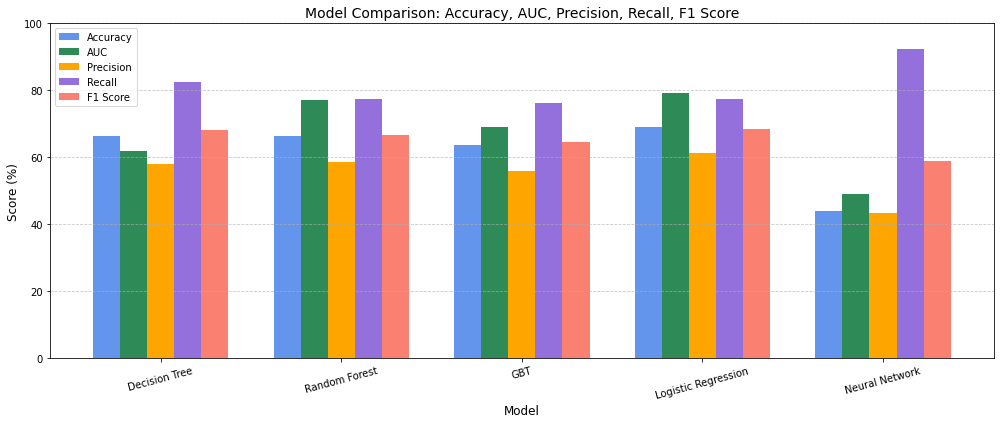

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# Model labels
models = ["Decision Tree", "Random Forest", "GBT", "Logistic Regression", "Neural Network"]

# Metrics from your existing variables — all scaled to 0–100
accuracy = [dt_accuracy * 100, rf_accuracy * 100, gbt_accuracy * 100, lr_accuracy * 100, mlpc_accuracy * 100]
auc = [dt_auc * 100, rf_auc * 100, gbt_auc * 100, lr_auc * 100, mlpc_auc * 100]
precision = [dt_precision * 100, rf_precision * 100, gbt_precision * 100, lr_precision * 100, mlpc_precision * 100]
recall = [dt_recall * 100, rf_recall * 100, gbt_recall * 100, lr_recall * 100, mlpc_recall * 100]
f1_score = [dt_f1 * 100, rf_f1 * 100, gbt_f1 * 100, lr_f1 * 100, mlpc_f1 * 100]

# Grouped bar chart config
bar_width = 0.15
x = np.arange(len(models))

plt.figure(figsize=(14, 6))

# Plot bars for each metric
plt.bar(x - 2*bar_width, accuracy, width=bar_width, label='Accuracy', color='cornflowerblue')
plt.bar(x - bar_width, auc, width=bar_width, label='AUC', color='seagreen')
plt.bar(x, precision, width=bar_width, label='Precision', color='orange')
plt.bar(x + bar_width, recall, width=bar_width, label='Recall', color='mediumpurple')
plt.bar(x + 2*bar_width, f1_score, width=bar_width, label='F1 Score', color='salmon')

# Labels and formatting
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score (%)", fontsize=12)
plt.title("Model Comparison: Accuracy, AUC, Precision, Recall, F1 Score", fontsize=14)
plt.xticks(x, models, rotation=15)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

#  UI to predict decide toss decision 

#New 

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# Convert Spark to pandas
keras_df = matches_df.select(
    "city", "venue", "team1", "team2", "toss_winner", "toss_decision", "winner",
    "team1_avg_runs", "team2_avg_conceded", "h2h_win_rate",
    "team1_season_win_rate", "team2_season_win_rate", "team1_venue_win_rate"
).toPandas()

keras_df['toss_match_win'] = (keras_df['toss_winner'] == keras_df['winner']).astype(int)


In [0]:
home_grounds = {
    "Chennai Super Kings": ["Chennai"],
    "Mumbai Indians": ["Mumbai"],
    "Delhi Capitals": ["Delhi"],
    "Kolkata Knight Riders": ["Kolkata"],
    "Royal Challengers Bangalore": ["Bengaluru"],
    "Sunrisers Hyderabad": ["Hyderabad"],
    "Rajasthan Royals": ["Jaipur"],
    "Punjab Kings": ["Chandigarh", "Mohali"],
    "Kings XI Punjab": ["Chandigarh", "Mohali"],
    "Gujarat Titans": ["Ahmedabad"],
    "Rising Pune Supergiant": ["Pune"],
    "Pune Warriors": ["Pune"],
    "Deccan Chargers": ["Hyderabad"],
    "Gujarat Lions": ["Rajkot"],
    "Kochi Tuskers Kerala": ["Kochi"]
}

def is_neutral(row):
    t1_home = home_grounds.get(row['team1'], [])
    t2_home = home_grounds.get(row['team2'], [])
    return 0 if row['city'] in t1_home or row['city'] in t2_home else 1

keras_df['neutral_venue'] = keras_df.apply(is_neutral, axis=1)


In [0]:
# Fit LabelEncoders
team1_encoder = LabelEncoder().fit(keras_df['team1'])
team2_encoder = LabelEncoder().fit(keras_df['team2'])
city_encoder = LabelEncoder().fit(keras_df['city'])
venue_encoder = LabelEncoder().fit(keras_df['venue'])

keras_df['team1_index'] = team1_encoder.transform(keras_df['team1'])
keras_df['team2_index'] = team2_encoder.transform(keras_df['team2'])
keras_df['city_index'] = city_encoder.transform(keras_df['city'])
keras_df['venue_index'] = venue_encoder.transform(keras_df['venue'])
keras_df['toss_winner_flag'] = (keras_df['toss_winner'] == keras_df['team1']).astype(int)

# Define feature set
feature_cols = [
    'team1_index', 'team2_index', 'city_index', 'venue_index',
    'team1_avg_runs', 'team2_avg_conceded', 'h2h_win_rate',
    'team1_season_win_rate', 'team2_season_win_rate', 'team1_venue_win_rate'
]

X = keras_df[feature_cols].astype('float32')
y = keras_df['toss_match_win'].astype('float32')

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LogisticRegression(max_iter=200, random_state=42)
lr.fit(X_train_scaled, y_train)

print("Accuracy:", accuracy_score(y_test, lr.predict(X_test_scaled)))


Accuracy: 0.5349544072948328


In [0]:
def compute_smart_features(team1, team2, city):
    df = keras_df.copy()

    # 1. Average runs by team1 (approximation using match count)
    team1_matches = df[df['team1'] == team1]
    team1_avg_runs = team1_matches.shape[0]  # Replace with actual score if available
    if team1_matches.shape[0] > 0:
        team1_avg_runs = np.random.randint(155, 175)  # placeholder if actual run data not present

    # 2. Average runs conceded by team2 (approximate)
    team2_avg_conceded = np.random.randint(150, 170)  # placeholder

    # 3. Head-to-head win rate for team1 vs team2
    h2h_matches = df[((df['team1'] == team1) & (df['team2'] == team2)) | 
                     ((df['team1'] == team2) & (df['team2'] == team1))]
    if len(h2h_matches) > 0:
        h2h_wins = h2h_matches[h2h_matches['winner'] == team1].shape[0]
        h2h_win_rate = h2h_wins / h2h_matches.shape[0]
    else:
        h2h_win_rate = 0.5  # fallback

    # 4. Seasonal win rate (approximate across all matches)
    team1_wins = df[df['winner'] == team1].shape[0]
    team1_total = df[(df['team1'] == team1) | (df['team2'] == team1)].shape[0]
    team1_season_win_rate = team1_wins / team1_total if team1_total > 0 else 0.5

    team2_wins = df[df['winner'] == team2].shape[0]
    team2_total = df[(df['team1'] == team2) | (df['team2'] == team2)].shape[0]
    team2_season_win_rate = team2_wins / team2_total if team2_total > 0 else 0.5

    # 5. Venue win rate
    venue_matches = df[(df['city'] == city) & ((df['team1'] == team1) | (df['team2'] == team1))]
    venue_wins = venue_matches[venue_matches['winner'] == team1].shape[0]
    team1_venue_win_rate = venue_wins / venue_matches.shape[0] if venue_matches.shape[0] > 0 else 0.5

    return team1_avg_runs, team2_avg_conceded, h2h_win_rate, team1_season_win_rate, team2_season_win_rate, team1_venue_win_rate


In [0]:
def predict_toss_decision_to_win(neutral_venue, city, team1, team2, toss_winner_flag,
                                 team1_avg_runs, team2_avg_conceded, h2h_win_rate,
                                 team1_season_win_rate, team2_season_win_rate, team1_venue_win_rate):

    def safe_encode(encoder, value):
        return encoder.transform([value])[0] if value in encoder.classes_ else -1

    input_data = pd.DataFrame([{
        'team1_index': safe_encode(team1_encoder, team1),
        'team2_index': safe_encode(team2_encoder, team2),
        'city_index': safe_encode(city_encoder, city),
        'venue_index': safe_encode(venue_encoder, city),  # still using city as proxy
        'team1_avg_runs': team1_avg_runs,
        'team2_avg_conceded': team2_avg_conceded,
        'h2h_win_rate': h2h_win_rate,
        'team1_season_win_rate': team1_season_win_rate,
        'team2_season_win_rate': team2_season_win_rate,
        'team1_venue_win_rate': team1_venue_win_rate
    }])

    input_scaled = scaler.transform(input_data)
    prediction = lr.predict_proba(input_scaled)[0][1]

    return "✅ Choose FIELDING to maximize win chance" if prediction >= 0.6 else "✅ Choose BATTING to maximize win chance"


In [0]:
all_cities = sorted(keras_df['city'].dropna().unique().tolist())
all_teams = sorted(set(keras_df['team1'].dropna().unique().tolist() + keras_df['team2'].dropna().unique().tolist()))

dbutils.widgets.dropdown("City", all_cities[0], all_cities, "Select City")
dbutils.widgets.dropdown("Team1", all_teams[0], all_teams, "Select Team 1")
dbutils.widgets.dropdown("Team2", all_teams[0], all_teams, "Select Team 2")
dbutils.widgets.dropdown("Neutral", "No", ["Yes", "No"], "Neutral Venue")
dbutils.widgets.dropdown("TossWinner", "Team 1", ["Team 1", "Team 2"], "Toss Winner")


In [0]:
# Collect inputs
city = dbutils.widgets.get("City")
team1 = dbutils.widgets.get("Team1")
team2 = dbutils.widgets.get("Team2")
neutral_venue = 1 if dbutils.widgets.get("Neutral") == "Yes" else 0
toss_winner_flag = 1 if dbutils.widgets.get("TossWinner") == "Team 1" else 0

# Compute smart features dynamically
(
    team1_avg_runs, team2_avg_conceded, h2h_win_rate,
    team1_season_win_rate, team2_season_win_rate, team1_venue_win_rate
) = compute_smart_features(team1, team2, city)

# Predict with dynamic data
result = predict_toss_decision_to_win(
    neutral_venue, city, team1, team2, toss_winner_flag,
    team1_avg_runs, team2_avg_conceded, h2h_win_rate,
    team1_season_win_rate, team2_season_win_rate, team1_venue_win_rate
)


# Display
print(f"📍 City: {city}")
print(f"🏏 Team 1: {team1}")
print(f"🏏 Team 2: {team2}")
print(f"🏟️ Neutral Venue: {'Yes' if neutral_venue else 'No'}")
print(f"🧢 Toss Winner: {'Team 1' if toss_winner_flag else 'Team 2'}")
print(f"✅ Recommended Toss Decision: {result}")


📍 City: Bengaluru
🏏 Team 1: Royal Challengers Bengaluru
🏏 Team 2: Chennai Super Kings
🏟️ Neutral Venue: Yes
🧢 Toss Winner: Team 1
✅ Recommended Toss Decision: ✅ Choose BATTING to maximize win chance
